<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/033_PyTorch_Neural_Network_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 PyTorch: Budujemy Mózg (nn.Module)

W PyTorch każda sieć neuronowa jest **Klasą**, która dziedziczy po `nn.Module`.
To standard, którego używa się w Tesli, OpenAI i Meta.

Szablon zawsze wygląda tak samo:
1.  **`__init__` (Konstruktor):** Tutaj kupujemy klocki (definiujemy warstwy: "Poproszę 2 warstwy liniowe").
2.  **`forward` (Przepływ):** Tutaj układamy klocki (definiujemy, jak dane płyną: "Wejdź do warstwy 1 -> zrób ReLU -> wejdź do warstwy 2").

Rozwiążemy problem klasyfikacji (zbiór `make_circles`), którego nie da się rozwiązać prostą kreską.

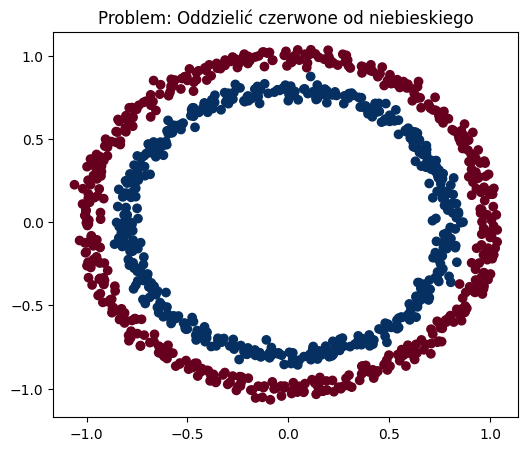

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# 1. PRZYGOTOWANIE DANYCH
# Tworzymy dwa okręgi (mniejszy wewnątrz większego)
# To problem nieliniowy!
X_np, y_np = make_circles(n_samples=1000, noise=0.03, random_state=42)

# Zamiana na Tensory PyTorch
# .float() jest ważne, bo PyTorch domyślnie woli float32
X = torch.from_numpy(X_np).type(torch.float)
y = torch.from_numpy(y_np).type(torch.float)

# Podział Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Wizualizacja
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
plt.title("Problem: Oddzielić czerwone od niebieskiego")
plt.show()

## Definiowanie Klasy Modelu

Stworzymy klasę `CircleModelV1`.
Zauważ użycie `super().__init__()` – to obowiązkowe, żeby PyTorch mógł robić swoją magię pod spodem.

Nasza architektura:
*   Wejście: 2 cechy (współrzędne X, Y).
*   Ukryta warstwa: 10 neuronów (żeby wygiąć przestrzeń).
*   Wyjście: 1 neuron (0 lub 1).

In [2]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # DEFINIUJEMY WARSTWY (Klocki)
        # nn.Linear(in_features, out_features)
        
        # Warstwa 1: Bierze 2 liczby (x,y), wypluwa 10 liczb (ukryte cechy)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        
        # Warstwa 2: Bierze 10 liczb, wypluwa 10 liczb (pogłębianie sieci)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        
        # Warstwa 3 (Wyjście): Bierze 10 liczb, wypluwa 1 (Decyzja)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
        # Funkcja aktywacji (ReLU - nasza "iskra")
        self.relu = nn.ReLU()

    def forward(self, x):
        # DEFINIUJEMY PRZEPŁYW DANYCH (Logika)
        # x -> Warstwa 1 -> ReLU -> Warstwa 2 -> ReLU -> Warstwa 3 -> Wynik
        
        z = self.layer_1(x)
        z = self.relu(z)
        z = self.layer_2(z)
        z = self.relu(z)
        z = self.layer_3(z)
        
        return z # Zwracamy surowe logity (bez Sigmoida na końcu, o tym zaraz)

# Tworzymy instancję modelu
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CircleModel().to(device)

print(f"Model stworzony i wysłany na: {device}")
print(model)

Model stworzony i wysłany na: cuda
CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


## Pętla Treningowa (Training Loop)

W Scikit-Learn pisaliśmy `model.fit()`. Tutaj musimy napisać to ręcznie.
To daje nam pełną kontrolę nad procesem.

Standardowa pętla PyTorch składa się z 5 kroków w każdej epoce:
1.  **Forward Pass:** Model robi predykcję.
2.  **Calculate Loss:** Sprawdzamy, jak bardzo się pomylił.
3.  **Zero Grad:** Czyścimy stare gradienty (żeby się nie sumowały).
4.  **Backward Pass:** Liczymy nowe gradienty (Autograd!).
5.  **Optimizer Step:** Aktualizujemy wagi.

In [3]:
# 1. Funkcja Kosztu (Loss Function)
# BCEWithLogitsLoss = Binary Cross Entropy + Sigmoid w jednym.
# To standard dla klasyfikacji binarnej (jest stabilniejsze matematycznie).
loss_fn = nn.BCEWithLogitsLoss()

# 2. Optymalizator (To on robi kroki w dół góry)
# SGD = Stochastic Gradient Descent
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

# Przenosimy dane na GPU (jeśli dostępne)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# 3. PĘTLA TRENINGOWA
epochs = 1000

for epoch in range(epochs):
    ### TRENING ###
    model.train() # Przełączamy w tryb treningu
    
    # 1. Forward
    y_logits = model(X_train).squeeze() # squeeze usuwa zbędny wymiar [[1], [0]] -> [1, 0]
    
    # 2. Loss
    loss = loss_fn(y_logits, y_train)
    
    # 3. Zero Grad
    optimizer.zero_grad()
    
    # 4. Backward
    loss.backward()
    
    # 5. Step
    optimizer.step()
    
    ### TESTOWANIE (Co 100 epok) ###
    if epoch % 100 == 0:
        model.eval() # Tryb ewaluacji (wyłącza np. Dropout)
        with torch.inference_mode(): # Wyłącza śledzenie gradientów (oszczędza pamięć)
            test_logits = model(X_test).squeeze()
            test_loss = loss_fn(test_logits, y_test)
            
            # Zamiana logitów na predykcję (Sigmoid -> Zaokrąglenie)
            test_pred = torch.round(torch.sigmoid(test_logits))
            acc = (test_pred == y_test).sum().item() / len(y_test)
            
        print(f"Epoka: {epoch} | Strata (Loss): {loss:.4f} | Dokładność Testowa: {acc*100:.1f}%")

Epoka: 0 | Strata (Loss): 0.6959 | Dokładność Testowa: 51.0%
Epoka: 100 | Strata (Loss): 0.6923 | Dokładność Testowa: 51.0%
Epoka: 200 | Strata (Loss): 0.6907 | Dokładność Testowa: 52.0%
Epoka: 300 | Strata (Loss): 0.6893 | Dokładność Testowa: 54.0%
Epoka: 400 | Strata (Loss): 0.6878 | Dokładność Testowa: 56.0%
Epoka: 500 | Strata (Loss): 0.6859 | Dokładność Testowa: 56.5%
Epoka: 600 | Strata (Loss): 0.6836 | Dokładność Testowa: 57.5%
Epoka: 700 | Strata (Loss): 0.6802 | Dokładność Testowa: 57.0%
Epoka: 800 | Strata (Loss): 0.6758 | Dokładność Testowa: 64.0%
Epoka: 900 | Strata (Loss): 0.6700 | Dokładność Testowa: 63.5%


--- CO WIDZI SIEĆ? ---


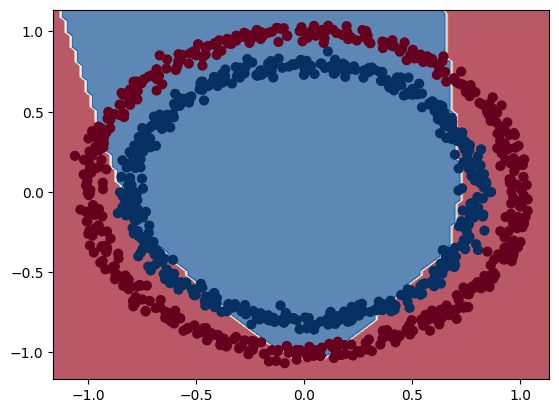

In [4]:
# WIZUALIZACJA GRANICY DECYZJI
# (Funkcja pomocnicza ściągnięta z dokumentacji, uproszczona)

def plot_decision_boundary(model, X, y):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    X_to_pred = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    
    with torch.no_grad():
        y_logits = model(X_to_pred)
        y_pred = torch.round(torch.sigmoid(y_logits)).reshape(xx.shape)
        
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

print("--- CO WIDZI SIEĆ? ---")
plot_decision_boundary(model, X, y)

## 🧠 Podsumowanie: Wolność kosztuje

W Scikit-Learn napisalibyśmy 3 linie kodu. Tutaj napisaliśmy 50.
Po co?

**Tu jest haczyk (Elastyczność).**
W `model.fit()` jesteś skazany na to, co wymyślił autor biblioteki.
W PyTorch pętla treningowa jest Twoja:
*   Możesz zmienić Learning Rate w połowie treningu.
*   Możesz mieć dwa różne Wejścia i trzy Wyjścia.
*   Możesz robić rzeczy, których nikt wcześniej nie robił (np. własna funkcja kosztu).

Teraz, gdy masz działającą klasę modelu i pętlę treningową, masz fundament do budowania **każdego** rodzaju sieci neuronowej – od rozpoznawania kotów po klony GPT.